In [1]:
#----------------------------------------------------------------------#
# Slow pion dataset creation script

# Data
import numpy as np
import awkward as ak
import pandas as pd
import dask
import dask.dataframe as dd

# I/O
import uproot as ur
import hipopy.hipopy as hp # <--- Package for reading in the hipo files

# Plotting
import matplotlib.pyplot as plt

# Physics
from particle import PDGID

# Miscellaneous
import os
import sys #NOTE: ADDED
import tqdm

# ML Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nbzv21q0 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#----------------------------------------------------------------------#
# HIPO bank reading and linking functions

def get_bank_keys(bank_name,all_keys,separator='_'):
    """
    :description: Get list of the keys for given bank name from a list of all batch keys.
    
    :param: bank_name
    :param: all_keys
    :param: separator='_'
    
    :return: bank_keys
    """
    bank_keys = []
    for key in all_keys:
        if key.startswith(bank_name+separator):
            bank_keys.append(key)
    return bank_keys
        
def get_event_table(bank_keys,event_num,batch,dtype=float):
    """
    :description: Get a bank event table as a numpy array of shape (number of columns, number of rows).
    
    :param: bank_keys
    :param: event_num
    :param: batch
    :param: dtype=float
    
    :return: bank_table
    """
    bank_table = []
    bank_table = np.moveaxis(np.array([batch[key][event_num] for key in bank_keys], dtype=dtype),[0,1],[1,0])
    return bank_table

def get_link_indices(event_table_rec_particle,event_table,pindex_idx=1):
    """
    :description: Get index pairs linking entries in a bank back to entries in the 'REC::Particle' bank.
    
    :param: event_table_rec_particle
    :param: event_table
    :param: pindex_idx=1
    
    :return: link_indices
    """
    
    link_indices = []
    nrec = np.shape(event_table_rec_particle)[0]
    for rec_particle_idx in range(0,nrec):
        for event_table_idx, el in enumerate(event_table[:,pindex_idx]):
            if el==rec_particle_idx:
                link_indices.append([rec_particle_idx,event_table_idx])
    return np.array(link_indices,dtype=int) #NOTE: link_indices = [(event_table_idx,rec_particle_idx)]

def get_parent_indices(mc_event_table,index_idx=0,parent_idx=4,daughter_idx=5):
    """
    TODO
    """
    for mc_event_table_idx, index in enumerate(mc_event_table[:,index_idx]):
        pass
    pass

def get_match_indices(
    rec_event_table,
    mc_event_table,
    rec_px_idx             = 1,
    rec_py_idx             = 2,
    rec_pz_idx             = 3,
    rec_ch_idx             = 8,
    mc_px_idx              = 6,
    mc_py_idx              = 7,
    mc_pz_idx              = 8,
    mc_pid_idx             = 3,
    mc_daughter_idx        = 5,
    match_charge           = True,
    require_no_mc_daughter = True,
    enforce_uniqueness     = True,
    ):
    """
    :description: Get index pairs matching 
    
    :param: rec_event_table
    :param: mc_event_table
    :param: rec_px_idx             = 1,
    :param: rec_py_idx             = 2,
    :param: rec_pz_idx             = 3,
    :param: rec_ch_idx             = 8,
    :param: mc_px_idx              = 6,
    :param: mc_py_idx              = 7,
    :param: mc_pz_idx              = 8,
    :param: mc_pid_idx             = 3,
    :param: mc_daughter_idx        = 5,
    :param: match_charge           = True,
    :param: require_no_mc_daughter = True,
    :param: enforce_uniqueness     = True,
    
    :return: match_indices
    """
    
    # Set minimum
    rec_final_state_min_idx = 1
    mc_final_state_min_idx  = 3 #NOTE: MC::Lund bank is structured [e, p, q, e', all the other final state particles...]
    
    # Initialize index map
    match_indices    = -np.ones((rec_event_table.shape[0],2),dtype=float)
    match_indices[0] = [0,3] #NOTE: Always match first entry in REC::Particle to scattered electron in MC::Lund.

    # Get REC::Particle info
    rec_px    = rec_event_table[:,rec_px_idx]
    rec_py    = rec_event_table[:,rec_py_idx]
    rec_pz    = rec_event_table[:,rec_pz_idx]
    rec_pT    = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx]))
    rec_p     = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx])+np.square(rec_event_table[:,rec_pz_idx]))
    rec_theta = np.array(rec_pz)
    rec_theta = np.arctan(rec_pT,rec_theta)
    rec_phi   = np.arctan2(rec_py,rec_px)
    
    # Get MC::Lund info
    mc_px    = mc_event_table[:,mc_px_idx]
    mc_py    = mc_event_table[:,mc_py_idx]
    mc_pz    = mc_event_table[:,mc_pz_idx]
    mc_pT    = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx]))
    mc_p     = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx])+np.square(mc_event_table[:,mc_pz_idx]))
    mc_theta = np.array(mc_pz)
    mc_theta = np.arctan(mc_pT,mc_theta)
    mc_phi   = np.arctan2(mc_py,mc_px)

    # Loop rec particles
    for rec_idx, rec_part in enumerate(rec_event_table):
        
        # Start with final state particles past scattered electron
        if rec_idx<rec_final_state_min_idx: continue
        
        # Get REC::Particle charge
        rec_ch = rec_event_table[rec_idx,rec_ch_idx]
        
        # Loop mc particles
        mc_match_idx = -1
        min_domega   = 9999
        for mc_idx, mc_part in enumerate(mc_event_table):
            
            # Start with final state particles past scattered electron
            if mc_idx<mc_final_state_min_idx:
                continue
            
            # Enforce unique matching
            if enforce_uniqueness and mc_idx in match_indices[:,1]:
                continue
            
            # Match charge and require that the MC particle be final state (no daughters)
            if match_charge and rec_ch!=PDGID(mc_event_table[mc_idx,mc_pid_idx]).charge:
                continue
            if require_no_mc_daughter and mc_event_table[mc_idx,mc_daughter_idx]!=0:
                continue
                
            # Get angular and momentum differences
            dp     = np.abs(rec_p[rec_idx]     - mc_p[mc_idx])
            dtheta = np.abs(rec_theta[rec_idx] - mc_theta[mc_idx])
            dphi   = np.abs(rec_phi[rec_idx]   - mc_phi[mc_idx]) if np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])<np.pi else 2*np.pi-np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])
            domega = dp**2 + dtheta**2 + dphi**2
            
            # Reset angular, momentum minimum difference
            if domega<min_domega:
                min_domega   = domega
                mc_match_idx = mc_idx
                
        # Append matched index pair
        match_indices[rec_idx] = [rec_idx,mc_match_idx]
        
    return np.array(match_indices,dtype=int) #NOTE: IMPORTANT!

def get_info(base_indices,link_indices,bank_entry_indices,bank_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    if link_indices is None:
        bank_info = []
        for base_idx in base_indices:
            base_info = bank_event_table[base_idx,bank_entry_indices]
            bank_info.append([base_info])
            
        return ak.Array(bank_info)
            
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, link_idx in link_indices:
            if rec_particle_idx==base_idx:
                base_info.append(bank_event_table[link_idx,bank_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(bank_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

def get_truth_info(base_indices,match_indices,truth_entry_indices,mc_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, match_idx in match_indices:
            if rec_particle_idx==base_idx:
                base_info.append(mc_event_table[match_idx,truth_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(truth_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

In [3]:
# #----------------------------------------------------------------------#
# # File iteration

# # Set input files, banks, and step size
# file_list = [
#      '/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/skim_50nA_OB_job_3313_0.hipo'
# ]
# banks = [
#     'REC::Particle',
#     'MC::Lund',
#     'REC::Traj',
# ]
# step  = 1000

# # Set padding dimension (gets multiplied by len(rec_traj_keys))
# max_linked_entries = 30

# # Set output files
data_file_name  = "data.txt"
truth_file_name = "truth.txt"
# !rm $data_file_name
# !rm $truth_file_name
# !ls -lrth *.txt
# delimiter       = ","
# replacement_header = "REPLACEMENT_HEADER"

# # Set entries to use as data/truth
# rec_particle_entry_indices = [1,2,3,4,5,6,7,9] # (pid), px, py, pz, vx, vy, vz, vt (Only in data), (charge), beta, (chi2pid), (status) #TODO: SET THESE OUTSIDE LOOPS
# rec_traj_entry_indices     = [2,3,4,5,6,7,8,9,10] # (pindex), (index), detector, layer, x, y, z, cx, cy, cz, path #TODO: SET THESE OUTSIDE LOOPS
# truth_entry_indices        = [11,12,13] # vx, vy, vz #TODO: SET THESE OUTSIDE LOOPS

# # Iterate hipo file
# for batch_num, batch in tqdm.tqdm(enumerate(hp.iterate(file_list,banks=banks,step=step))):
    
#     # Set bank names and entry names to look at
#     all_keys          = list(batch.keys())
#     rec_particle_name = 'REC::Particle'
#     rec_particle_keys = get_bank_keys(rec_particle_name,all_keys)
#     mc_lund_name      = 'MC::Lund'
#     mc_lund_keys      = get_bank_keys(mc_lund_name,all_keys)
#     rec_traj_name     = 'REC::Traj'
#     rec_traj_keys     = get_bank_keys(rec_traj_name,all_keys)
    
#     # Loop events in batch
#     batch_info  = None
#     batch_truth = None
#     for event_num, _ in enumerate(range(0,len(batch[list(batch.keys())[0]]))):
        
#         # Get pion indices in REC::Particle (if they exist)
#         filter_pid   = -211
#         rec_pid_idx  = 0
#         base_indices = np.where(np.array(batch['REC::Particle_pid'][event_num],dtype=object)==filter_pid)[0]
#         if len(base_indices)<1: continue #NOTE: Check that particles of interest actually present in event
        
#         # Get REC::Particle bank
#         rec_particle_event_table = get_event_table(rec_particle_keys,event_num,batch,dtype=float)
        
#         # Get MC::Lund bank and MC->REC matching indices
#         mc_event_table = get_event_table(mc_lund_keys,event_num,batch,dtype=float)
#         match_indices  = get_match_indices(rec_particle_event_table,mc_event_table)#TODO: This is somehow resetting rec_particle_event_table...
#         if np.max(match_indices[:,-1])==-1: continue #NOTE: Check that particles actually get matched can also check that this is the case for base_indices...
        
#         # Get REC::Traj bank and linking indices to REC::Particle
#         rec_traj_event_table  = get_event_table(rec_traj_keys,event_num,batch,dtype=float)
#         rec_traj_link_indices = get_link_indices(rec_particle_event_table,rec_traj_event_table,pindex_idx=1)
        
#         # Get linked info for REC::Particle bank
#         rec_particle_info = get_info(base_indices,None,rec_particle_entry_indices,rec_particle_event_table)
        
#         # Get linked info for REC::Traj bank
#         rec_traj_info     = get_info(base_indices,rec_traj_link_indices,rec_traj_entry_indices,rec_traj_event_table)
        
#         # Get linked info for REC::Traj bank
#         truth_info        = get_truth_info(base_indices,match_indices,truth_entry_indices,mc_event_table)
        
#         #TODO: Could add optional computation of REC/MC kinematics assuming trigger particle is first...should add check for that though

#         #----------------------------------------------------------------------#
#         #NOTE: Have truth array of dim (nEvents,nPions,nTruth=nVtx=3 right now)
#         #
#         #----------------------------------------------------------------------#

#         #----------------------------------------------------------------------#
#         # TODO: Here have 3 options:
#         # 1. Create pyg graphs EVENT-BY-EVENT                                      -> GNN
#         # 2. Create awkward arrays of dim (nPions,nBanks(X)nEntries,nCols->PADDED) -> CNN
#         # 3. Create awkward arrays of dim (nPions,nBanks(X)nEntries*nCols->PADDED) -> NN
#         #----------------------------------------------------------------------#
        
#         #NOTE: OPTION 3 ACTUAL: Create event data array of dim (nPions,nBanks(X)nEntries*nCols->PADDED=(1*8*1+1*9*25(PAD))=233)
#         event_truth       = ak.to_numpy(ak.flatten(truth_info,axis=-1)) #NOTE: THESE NEED TO BE NUMPY ARRAYS TO WRITE WITH np.savetxt() BELOW
#         rec_particle_info = ak.to_numpy(ak.flatten(rec_particle_info,axis=-1))
#         rec_traj_info     = ak.flatten(rec_traj_info,axis=-1)
#         targetD           = max_linked_entries*len(rec_traj_entry_indices)
#         rec_traj_info     = np.nan_to_num(np.ma.array(ak.to_numpy(ak.pad_none(rec_traj_info,targetD,axis=-1))))#np.clip(np.nan_to_num(),1e-100,1e+100)
#         rec_traj_info[rec_traj_info.mask] = 0.0 #NOTE: RESET PADDED ENTRIES TO ZERO.  THERE'S GOT TO BE AN EASIER WAY TO JUST PAD WITH ZEROS THOUGH.
#         event_info        = np.concatenate((rec_particle_info,rec_traj_info),axis=1)
        
#         # Append event level data to batch level data
#         batch_info  = np.concatenate((batch_info,event_info),axis=0) if batch_info is not None else np.array(event_info)#NOTE: CHECK THIS...
#         batch_truth = np.concatenate((batch_truth,event_truth),axis=0) if batch_truth is not None else np.array(event_truth)#NOTE: CHECK THIS...
    
#     # Write batch data to file
#     fmt = ["%.3g" for i in range(np.shape(batch_info)[1])]
#     with open(data_file_name, "ab" if batch_num>0 else "wb") as f:
#         rec_particle_header = [rec_particle_keys[idx] for idx in rec_particle_entry_indices]
#         rec_traj_header = [key+'_'+str(i) for key in [rec_traj_keys[idx] for idx in rec_traj_entry_indices] for i in range(max_linked_entries)]
#         header = replacement_header+delimiter.join([*rec_particle_header, *rec_traj_header]) if batch_num==0 else "" #NOTE: NOT GENERALIZED
#         np.savetxt(f, batch_info, header=header, delimiter=delimiter, fmt=fmt)
        
#     # Write batch truth to file
#     fmt = ["%.3g" for i in range(np.shape(batch_truth)[1])]
#     with open(truth_file_name, "ab" if batch_num>0 else "wb") as f:
#         header = replacement_header+delimiter.join([mc_lund_keys[idx] for idx in truth_entry_indices]) if batch_num==0 else "" #NOTE: NOT GENERALIZED
#         np.savetxt(f, batch_truth, header=header, delimiter=delimiter, fmt=fmt)
        
# #     if batch_num>3: break#DEBUGGING

In [4]:
# Remove replacement header
def remove_replacement_header(filename,replacement_header="REPLACEMENT_HEADER"):
    # Read in the file
    with open(filename, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('# '+replacement_header, '')

    # Write the file out again
    with open(filename, 'w') as file:
        file.write(filedata)

# Remove replacement header to remove `#` introduced by np.savetxt
remove_replacement_header(data_file_name,replacement_header=replacement_header)
remove_replacement_header(truth_file_name,replacement_header=replacement_header)

NameError: name 'replacement_header' is not defined

In [ ]:
!grep $replacement_header $data_file_name
!grep $replacement_header $truth_file_name

#----- !rm $data_file_name
#----- !rm $truth_file_name

In [9]:
import pandas as pd
df = dd.read_csv(data_file_name,dtype=np.float64)
len(df[["REC::Particle_px"]])

173214

DEBUGGING: df['REC::Particle_vy'].max() =  dd.Scalar<series-..., dtype=float64>
DEBUGGING: df['REC::Particle_vy'].max() =  dd.Scalar<series-..., dtype=float64>


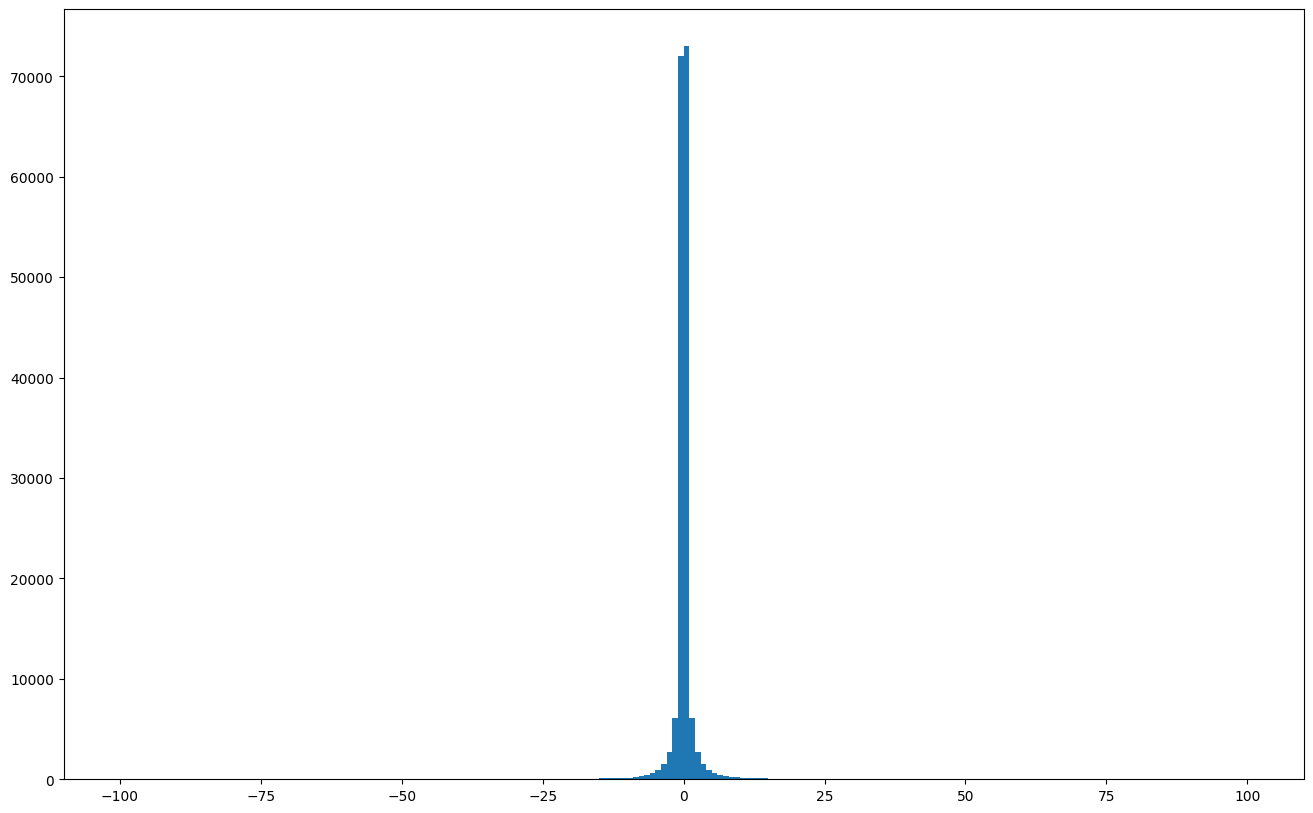

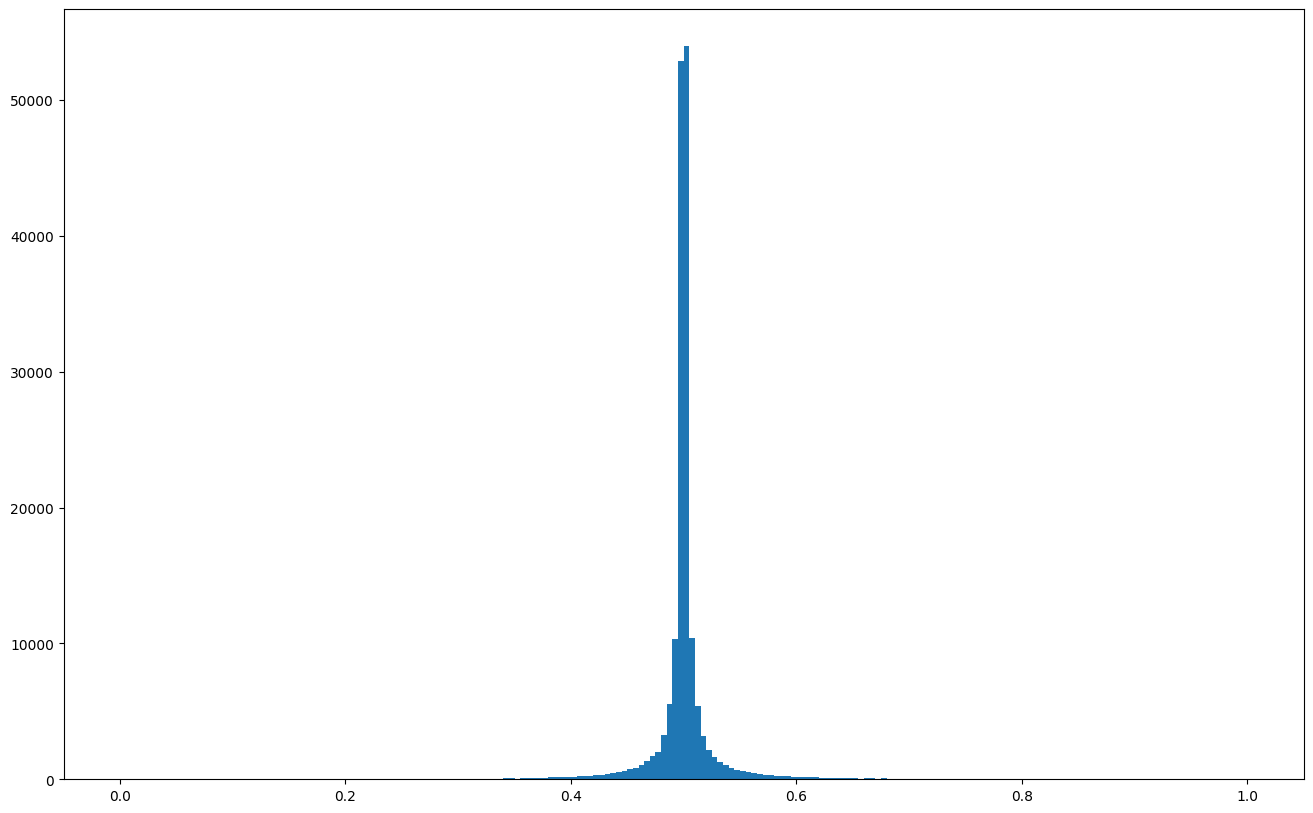

In [10]:
figsize = (16,10)
nbins = 200
f1 = plt.figure(figsize=figsize)
print("DEBUGGING: df['REC::Particle_vy'].max() = ",df['REC::Particle_vy'].max())
low_high = (-100,100)
a1 = plt.hist((df['REC::Particle_vy']+0)*1,bins=nbins,range=low_high)

f2 = plt.figure(figsize=figsize)
nbins = 200
print("DEBUGGING: df['REC::Particle_vy'].max() = ",df['REC::Particle_vy'].max())
low_high = (0,1)
a2 = plt.hist((df['REC::Particle_vy']+25)/50,bins=nbins,range=low_high)
plt.show()

In [1]:
data_file_name  = "data.txt"
truth_file_name = "truth.txt"
# print("DEBUGGING: df.shape = ",df.shape)

DEBUGGING: self.data.dtype  =  float64
DEBUGGING: self.truth.dtype =  float64
DEBUGGING: rec_traj_layer_idcs    =  [8, 17, 26, 35, 44, 53, 62, 71, 80, 89, 98, 107, 116, 125, 134, 143, 152, 161, 170, 179, 188, 197, 206, 215, 224, 233, 242, 251, 260, 269]
DEBUGGING: rec_traj_detector_idcs =  [9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270]
DEBUGGING: rec_traj_x_idcs        =  [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, 109, 118, 127, 136, 145, 154, 163, 172, 181, 190, 199, 208, 217, 226, 235, 244, 253, 262, 271]
DEBUGGING: rec_traj_y_idcs        =  [11, 20, 29, 38, 47, 56, 65, 74, 83, 92, 101, 110, 119, 128, 137, 146, 155, 164, 173, 182, 191, 200, 209, 218, 227, 236, 245, 254, 263, 272]
DEBUGGING: rec_traj_z_idcs        =  [12, 21, 30, 39, 48, 57, 66, 75, 84, 93, 102, 111, 120, 129, 138, 147, 156, 165, 174, 183, 192, 201, 210, 219, 228, 237, 246, 255, 264, 273]
DEBUGGING: rec_traj_cx_idcs       = 

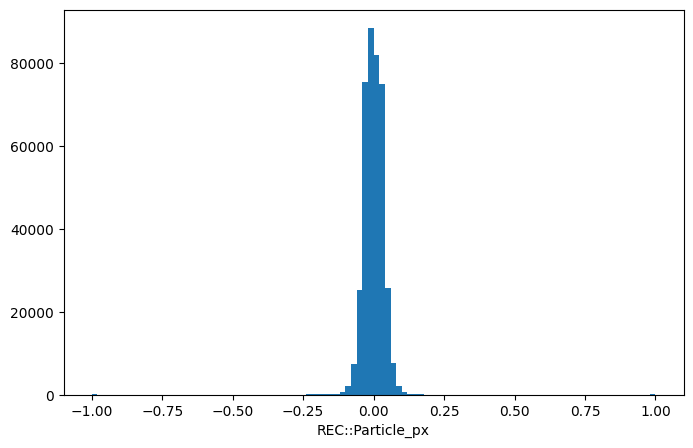

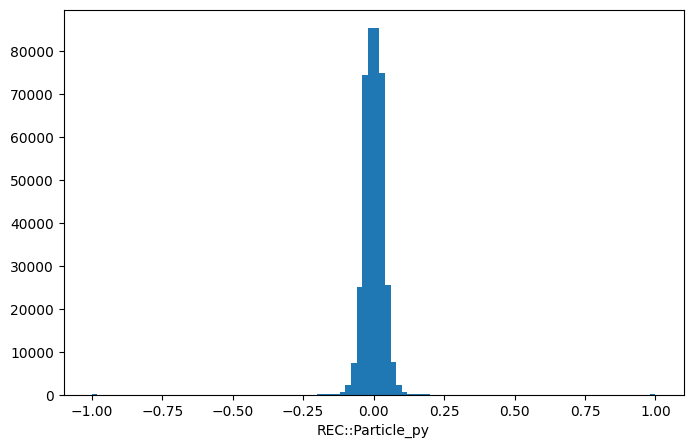

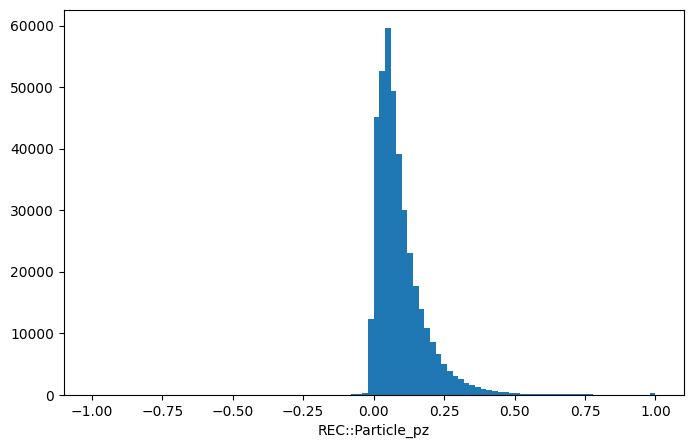

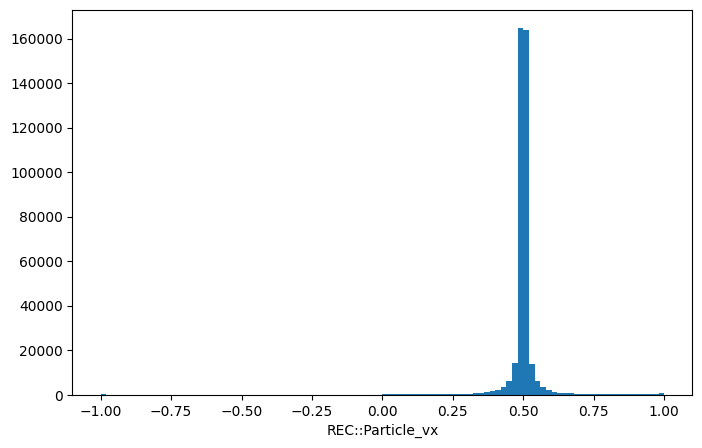

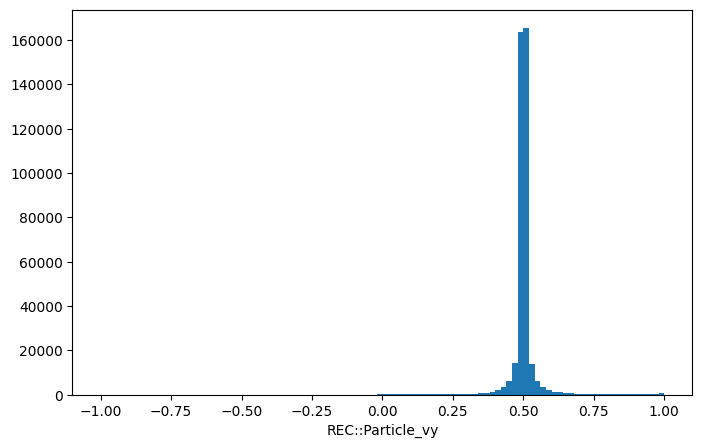

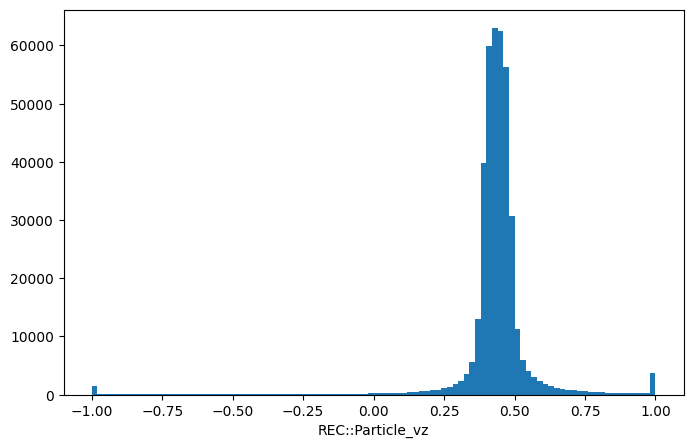

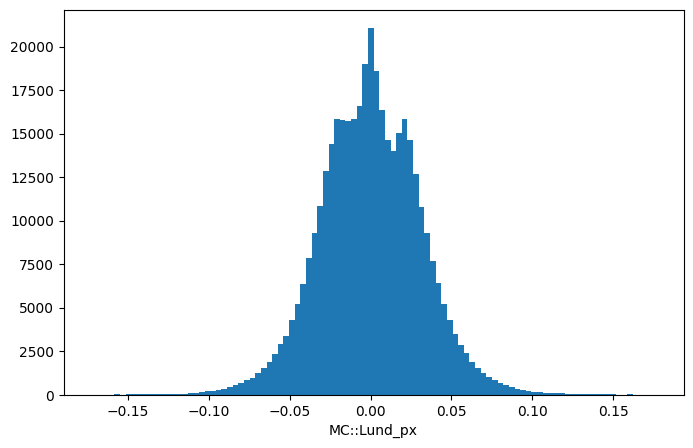

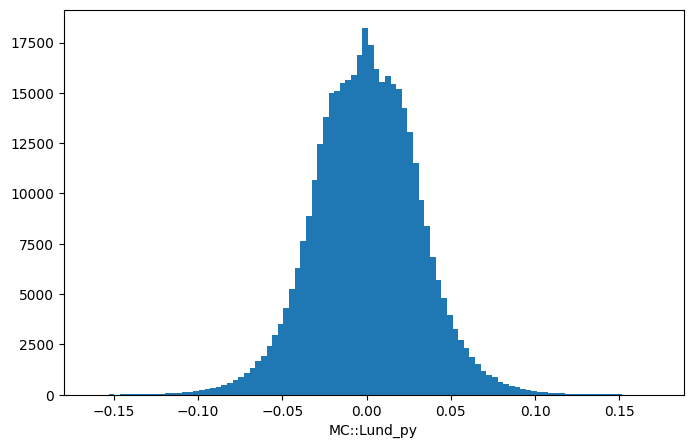

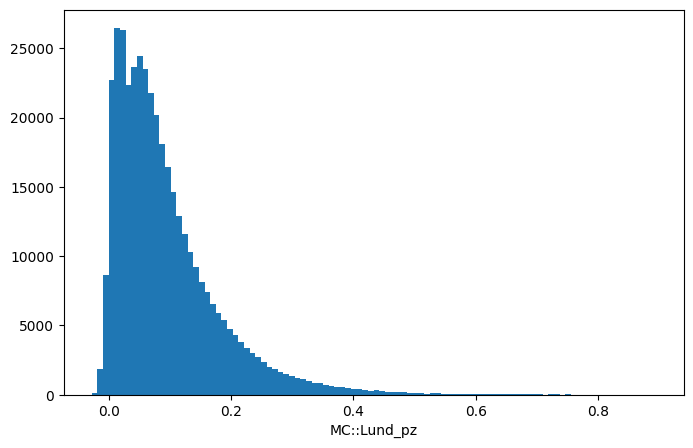

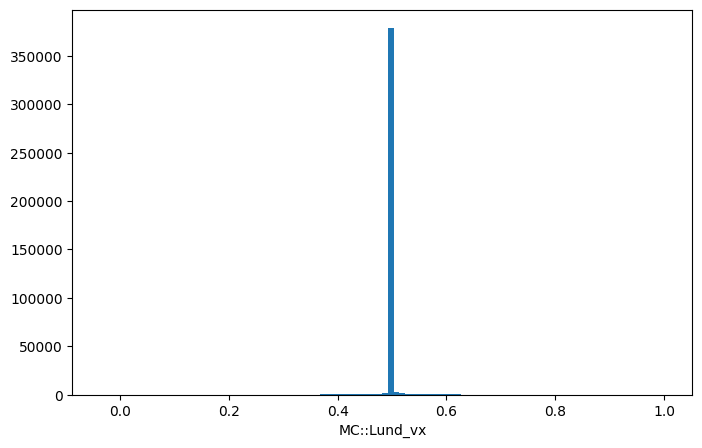

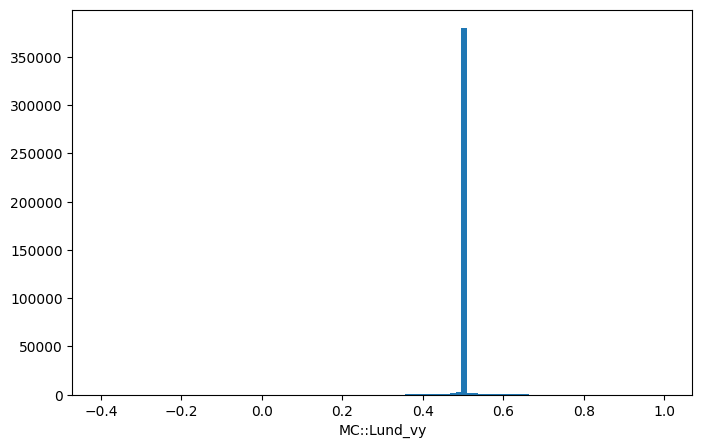

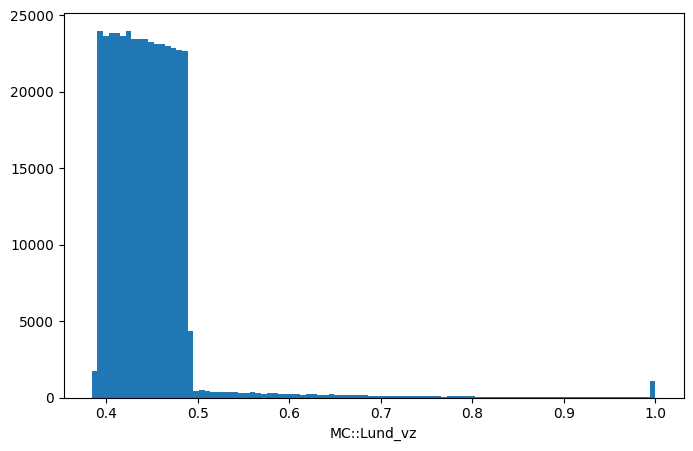

In [94]:
import dask.dataframe as dd
class CustomDataset(Dataset):
    """Custom dataset."""

    def __init__(self, root_dir='.', data_file='data.txt', truth_file='truth.txt', transform=None):
        """
        :param: root_dir (string, optional): Name of root directory containing data_file and truth_file
        :param: data_file (string, optional): Name of data file
        :param: truth_file (string, optional): Name of truth file
        :param: transform (callable, optional): Optional transform to be applied to data entries
        """
        self.root_dir   = root_dir
        self.data_file  = data_file
        self.truth_file = truth_file
        self.transform  = transform
        
        # Load data
        self.data  = dd.read_parquet(os.path.join(root_dir,data_file),dtype=float) #TODO: ADD OPTION FOR USING PANDAS OR DASK
        self.truth = dd.read_parquet(os.path.join(root_dir,truth_file),dtype=float)
        self.data_keys = self.data.columns
        self.truth_keys = self.truth.columns
#         self.data = self.data.iloc[:10, :15]#DEBUGGING!
#         self.truth = self.truth.iloc[:10, :15]#DEBUGGING!
#         print("DEBUGGING: self.data = ",self.data)
#         print("DEBUGGING: self.data[0:10] = \n",self.data[0:10].iloc[12,21,30,111,120,129])
        
        # Convert to torch tensors
        self.data  = self.data.values #NOTE: dtype needs to match weights in NN which are torch.float32 by default.
        self.truth = self.truth.values
        
        print("DEBUGGING: self.data.dtype  = ",self.data.dtype)
        print("DEBUGGING: self.truth.dtype = ",self.truth.dtype)
        
    def to_numpy(self,dtype=float):
        self.data  = np.array(self.data,dtype=dtype)
        self.truth = np.array(self.truth,dtype=dtype)
        
    def to_torch(self,dtype=torch.float32):
        self.data  = torch.Tensor(self.data).to(dtype)
        self.truth = torch.Tensor(self.truth).to(dtype)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = (self.data[idx], self.truth[idx]) #NOTE: IMPORTANT: Need `.iloc[idx]` if self.data, self.truth are pandas dataframes!

        if self.transform:
            sample = self.transform(sample)

        return sample

# Create dataset and split
root_dir = '.'
data_file = 'data.txt'
truth_file = 'truth.txt'
data_file = '/volatile/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023_jobs_12_5_23_BACKUP/xyz_full_skim_50nA_OB_job_3313_0.hipo.csv_*.parquet' #NOTE: CANNOT DISTRIBUTE DATALOADER OF PYTORCH SO FAR AS I KNOW BUT CAN USE DASK TO DISTRIBUTE MODEL TRAINING ACROSS DIFFERENT WORKERS WITH THEIR OWN INDIVIDUAL DATALOADERS.
truth_file = '/volatile/clas12/users/mfmce/CLAS12_Lambda_resolution_REU_2023_jobs_12_5_23_BACKUP/ptp_full_skim_50nA_OB_job_3313_0.hipo.csv_*.parquet'
# data_file = 'data_test.csv'
# truth_file = 'truth_test.csv'
def transform(sample):
    
    x, y = sample
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[pz_index] /= 10.0
    x[pz_index] /= 10.0
    x[pz_index] /= 10.0
    x[vx_index] -= -25.0
    x[vx_index] /= 50.0
    x[vy_index] -= -25.0
    x[vy_index] /= 50.0
    x[vz_index] -= -25.0
    x[vz_index] /= 50.0
    x[vt_index] -= 124.25
    x[bt_index] -= 1.0
    x[rec_traj_min_idx:] /= 1000.0
    
    # Set indices
    vx_true_index = 0
    vy_true_index = 1
    vz_true_index = 2
    
    # Reassign values in y
    y[vx_true_index] -= -25.0
    y[vx_true_index] /= 50.0
    y[vy_true_index] -= -25.0
    y[vy_true_index] /= 50.0
    y[vz_true_index] -= -25.0
    y[vz_true_index] /= 50.0
    
    # NOTE: Double check data before doing this.
    x = torch.clamp(x,-1,1)
    y = torch.clamp(y,-1,1)
    
    return x, y
    
dataset = CustomDataset(root_dir=root_dir,data_file=data_file,truth_file=truth_file,transform=None)
dataset.data.compute_chunk_sizes() #NOTE: FOR DASK ARRAYS
dataset.truth.compute_chunk_sizes()
dataset.data.persist() #NOTE: THESE ARE ONLY NEEDED FOR CREATING DATALOADERS BELOW.
dataset.truth.persist()
dataset.to_numpy() #NOTE: ONLY NEEDED FOR CREATING PYTORCH DATALOADER BELOW.
dataset.to_torch()

def pretransform(ds):
    
    x, y = ds
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    max_linked_entries = 30
    rec_traj_max_entries = 9
    
    rec_traj_layer_idcs = [rec_traj_min_idx+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_detector_idcs = [rec_traj_min_idx+1+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_x_idcs = [rec_traj_min_idx+2+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_y_idcs = [rec_traj_min_idx+3+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_z_idcs = [rec_traj_min_idx+4+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cx_idcs = [rec_traj_min_idx+5+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cy_idcs = [rec_traj_min_idx+6+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_cz_idcs = [rec_traj_min_idx+7+i*rec_traj_max_entries for i in range(max_linked_entries)]
    rec_traj_path_idcs = [rec_traj_min_idx+8+i*rec_traj_max_entries for i in range(max_linked_entries)]
    
    print("DEBUGGING: rec_traj_layer_idcs    = ",rec_traj_layer_idcs)
    print("DEBUGGING: rec_traj_detector_idcs = ",rec_traj_detector_idcs)
    print("DEBUGGING: rec_traj_x_idcs        = ",rec_traj_x_idcs)
    print("DEBUGGING: rec_traj_y_idcs        = ",rec_traj_y_idcs)
    print("DEBUGGING: rec_traj_z_idcs        = ",rec_traj_z_idcs)
    print("DEBUGGING: rec_traj_cx_idcs       = ",rec_traj_cx_idcs)
    print("DEBUGGING: rec_traj_cy_idcs       = ",rec_traj_cy_idcs)
    print("DEBUGGING: rec_traj_cz_idcs       = ",rec_traj_cz_idcs)
    print("DEBUGGING: rec_traj_path_idcs     = ",rec_traj_path_idcs)
    
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[:,px_index] /= 10.0
    x[:,py_index] /= 10.0
    x[:,pz_index] /= 10.0
    x[:,vx_index] -= -25.0
    x[:,vx_index] /= 50.0
    x[:,vy_index] -= -25.0
    x[:,vy_index] /= 50.0
    x[:,vz_index] -= -25.0
    x[:,vz_index] /= 50.0
    x[:,vt_index] -= 124.25
    x[:,bt_index] -= 1.0
    for idx in rec_traj_layer_idcs:
        x[:,idx] /= 50
    for idx in rec_traj_detector_idcs:
        x[:,idx] /= 50
    for idx in rec_traj_x_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_y_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_z_idcs:
        x[:,idx] /= 1000.0
    for idx in rec_traj_path_idcs:
        x[:,idx] /= 1000.0
    
    # Set indices
    px_true_index = 0
    py_true_index = 1
    pz_true_index = 2
    vx_true_index = 3
    vy_true_index = 4
    vz_true_index = 5
    
    # Reassign values in y
    y[:,px_index] /= 10.0
    y[:,py_index] /= 10.0
    y[:,pz_index] /= 10.0
    y[:,vx_true_index] -= -25.0
    y[:,vx_true_index] /= 50.0
    y[:,vy_true_index] -= -25.0
    y[:,vy_true_index] /= 50.0
    y[:,vz_true_index] -= -25.0
    y[:,vz_true_index] /= 50.0
    
    # NOTE: Double check data before doing this.
    x = torch.clamp(x,-1,1)
    y = torch.clamp(y,-1,1)
    
    return x, y

#NOTE: PRETRANSFORM DATASET FOR NOW
dataset.data, dataset.truth = pretransform((dataset.data,dataset.truth))

print("DEBUGGING: dataset.data.max() = ",dataset.data.max())
print("DEBUGGING: dataset.data.min() = ",dataset.data.min())
print("DEBUGGING: dataset.truth.max() = ",dataset.truth.max())
print("DEBUGGING: dataset.truth.min() = ",dataset.truth.min())
print("DEBUGGING: type(dataset.data) = ",type(dataset.data))
print("DEBUGGING: dataset.data.shape = ",dataset.data.shape)
print("DEBUGGING: len(dataset.data)  = ",len(dataset.data))
# print("DEBUGGING: len(dataset.data.to_numpy())  = ",len(dataset.data.to_numpy()))
train_data, val_data, test_data = random_split(dataset,(0.8,0.1,0.1))
# print(dataset[0])

# df = dd.read_parquet(os.path.join(root_dir,data_file),dtype=np.float64)
# df.compute()

def transform_ds(x):
    
    # Set indices
    px_index = 0
    py_index = 1
    pz_index = 2
    vx_index = 3
    vy_index = 4
    vz_index = 5
    vt_index = 6
    bt_index = 7
    rec_traj_min_idx = 8
    
    # Calculate additional quantities if needed here before you reassign anything in x
    
    # Reassign values in x
    x[:,px_index] /= 10.0
    x[:,py_index] /= 10.0
    x[:,pz_index] /= 10.0
    x[:,vx_index] -= -25.0
    x[:,vx_index] /= 50.0
    x[:,vy_index] -= -25.0
    x[:,vy_index] /= 50.0
    x[:,vz_index] -= -25.0
    x[:,vz_index] /= 50.0
    x[:,vt_index] -= 124.25
    x[:,bt_index] -= 1.0
    x[:,rec_traj_min_idx:] /= 1000.0
    
    x = torch.clamp(x,-1,1)
    
    return x

print("DEBUGGING: len(dataset.data[dataset.data>1])  = ",len(dataset.data[dataset.data>1]))
print("DEBUGGING: len(dataset.data[dataset.data<-1]) = ",len(dataset.data[dataset.data<-1]))
print("DEBUGGING: ",end="\n")
print("DEBUGGING: BEFORE: np.shape(dataset.data) = ",np.shape(dataset.data))
# dataset.data = transform_ds(dataset.data)
print("DEBUGGING: AFTER: np.shape(dataset.data) = ",np.shape(dataset.data))
figs = []
for j in range(np.shape(dataset.data)[1]):
    x = dataset.data[:,j]
    figs.append(plt.figure(figsize=(8,5)))
    plt.hist(x,bins=100,range=(x.min().item(),x.max().item()))
    plt.xlabel(dataset.data_keys[j])
    print("\t j, col, min, mean, max, std = ",
          j,
          dataset.data_keys[j],
          dataset.data[:,j].min(),
          dataset.data[:,j].mean(),
          dataset.data[:,j].max(),
          dataset.data[:,j].std()
         )
    if j > 4: break
        
#NOTE: REPEAT FOR TRUTH INFO
for j in range(np.shape(dataset.truth)[1]):
    x = dataset.truth[:,j]
    figs.append(plt.figure(figsize=(8,5)))
    plt.hist(x,bins=100,range=(x.min().item(),x.max().item()))
    plt.xlabel(dataset.truth_keys[j])
    print("\t j, col, min, mean, max, std = ",
          j,
          dataset.truth_keys[j],
          dataset.truth[:,j].min(),
          dataset.truth[:,j].mean(),
          dataset.truth[:,j].max(),
          dataset.truth[:,j].std()
         )
#     if j > 4: break
    
plt.show()

In [97]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=True) #NOTE: IMPORTANT TO SET DROP_LAST=TRUE IF DATASET IS NOT PERFECTLY MATCHED WITH BATCH_SIZE
val_dataloader   = DataLoader(val_data,   batch_size=batch_size, drop_last=True)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, drop_last=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
# print("DEBUGGING: len(test_dataloader.dataset) = ",len(test_dataloader.dataset))
# print("DEBUGGING: test_dataloader.dataset[0][1] = ",test_dataloader.dataset[0][1])
# print("DEBUGGING: len(torch.tensor([el[1] for el in test_dataloader.dataset])) = ",len(torch.tensor([el[1] for el in test_dataloader.dataset])))

Shape of X [N, C, H, W]: torch.Size([64, 278])
Shape of y: torch.Size([64, 6]) torch.float32


In [98]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

314139
39267
39267


In [99]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
#         print("DEBUGGING: in model.forward(): x.dtype = ",x.dtype)
#         print("DEBUGGING: type(model.parameters()) = ",type(model.parameters()))
#         print("DEBUGGING: dtypes of model.parameters() = ",[ el.dtype for el in list(model.parameters())])
        logits = self.linear_relu_stack(x)
        return logits

input_dim  = dataset[0][0].shape[-1]
output_dim = dataset[0][1].shape[-1]
print("DEBUGGING: input_dim = ",input_dim)
print("DEBUGGING: output_dim = ",output_dim)
model = NeuralNetwork(input_dim,output_dim).to(device)#.to(torch.float32) <- default for torch model weights is torch.float32
print(model)

Using cuda device
DEBUGGING: input_dim =  278
DEBUGGING: output_dim =  6
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=278, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=6, bias=True)
  )
)


In [122]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [123]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
#         print("DEBUGGING: batch = ",batch)
        X, y = X.to(device), y.to(device)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: np.array(model.weights)",np.array(model.weights).dtype)
        if torch.any(torch.isnan(X)):
            print("FOUND NAN IN INPUT")
        if torch.any(torch.isnan(y)):
            print("FOUND NAN IN LABEL")
        if X.shape[0]!=batch_size:
            print("DEBUGGING: X.shape = ",X.shape)
            print("DEBUGGING: y.shape = ",y.shape)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: y.dtype = ",y.dtype)
#         print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#         print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\r loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end="")
            losses.append(loss)
    return np.mean(losses)

In [124]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    fractional_diffs = torch.zeros(output_dim).to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#             correct = torch.add(fractional_diffs,torch.divide((pred - y),y))
    test_loss /= num_batches
#     correct /= size
    print(f"\nTest Error: \n Avg loss: {test_loss:>8f} \n")
    
    return test_loss

In [ ]:
epochs = 50
train_losses = []
val_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = val(val_dataloader, model, loss_fn)
#     print("DEBUGGING: type(train_loss) = ",type(train_loss))
#     print("DEBUGGING: type(val_loss) = ",type(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
print("Done!")

Epoch 1
-------------------------------
 loss: 0.001715  [313664/314139]
Test Error: 
 Avg loss: 0.000834 

Epoch 2
-------------------------------
 loss: 0.001644  [313664/314139]
Test Error: 
 Avg loss: 0.000809 

Epoch 3
-------------------------------
 loss: 0.001714  [313664/314139]
Test Error: 
 Avg loss: 0.000787 

Epoch 4
-------------------------------
 loss: 0.001626  [313664/314139]
Test Error: 
 Avg loss: 0.000765 

Epoch 5
-------------------------------
 loss: 0.001591  [313664/314139]
Test Error: 
 Avg loss: 0.000752 

Epoch 6
-------------------------------
 loss: 0.001468  [313664/314139]
Test Error: 
 Avg loss: 0.000735 

Epoch 7
-------------------------------
 loss: 0.001434  [313664/314139]
Test Error: 
 Avg loss: 0.000729 

Epoch 8
-------------------------------
 loss: 0.001439  [313664/314139]
Test Error: 
 Avg loss: 0.000726 

Epoch 9
-------------------------------
 loss: 0.001378  [313664/314139]
Test Error: 
 Avg loss: 0.000723 

Epoch 10
-------------------

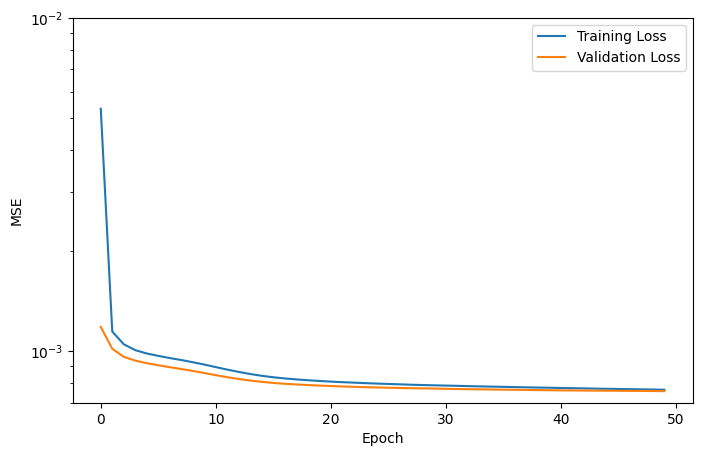

In [117]:
f = plt.figure(figsize=(8,5))
plt.semilogy([i for i in range(epochs)],train_losses,color='tab:blue',label='Training Loss')
plt.semilogy([i for i in range(epochs)],val_losses,color='tab:orange',label='Validation Loss')
plt.ylim((7*1e-4,1e-2))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')

DEBUGGING: size =  39267
DEBUGGING: num_batches =  613
Test Error: 
 Avg loss: 0.000759 

DEBUGGING: inputs.shape =  torch.Size([39232, 278])
DEBUGGING: correct.shape =  torch.Size([39232, 6])
DEBUGGING: preds.shape =  torch.Size([39232, 6])
DEBUGGING: tests.shape =  torch.Size([39232, 6])

DEBUGGING: correct.min() =  -0.607196569442749
DEBUGGING: preds.min() =  -0.1787777543067932
DEBUGGING: tests.min() =  -0.17191000282764435

DEBUGGING: correct.max() =  0.46291327476501465
DEBUGGING: preds.max() =  0.6307774782180786
DEBUGGING: tests.max() =  1.0

DEBUGGING: correct.mean() =  0.0005869251326657832
DEBUGGING: preds.mean() =  0.25702863931655884
DEBUGGING: tests.mean() =  0.25644171237945557

DEBUGGING: correct.std() =  0.027544474229216576
DEBUGGING: preds.std() =  0.2328859567642212
DEBUGGING: tests.std() =  0.23285655677318573
DEBUGGING: target label =  MC::Lund_px
DEBUGGING: mean Delta   =  tensor(0.0074)
DEBUGGING: std Delta    =  tensor(0.1470)
DEBUGGING: mean orig Delta   =  te

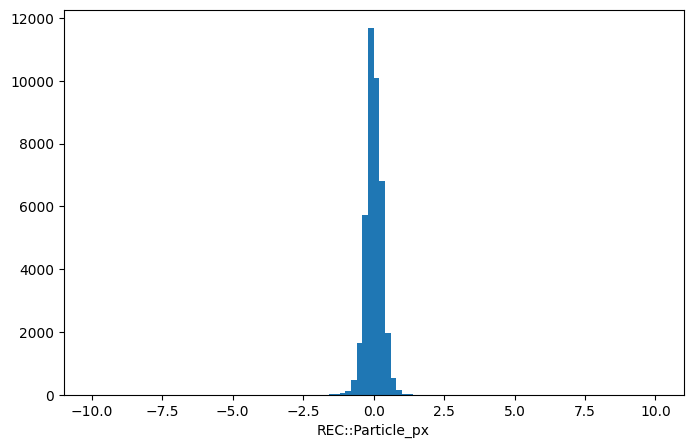

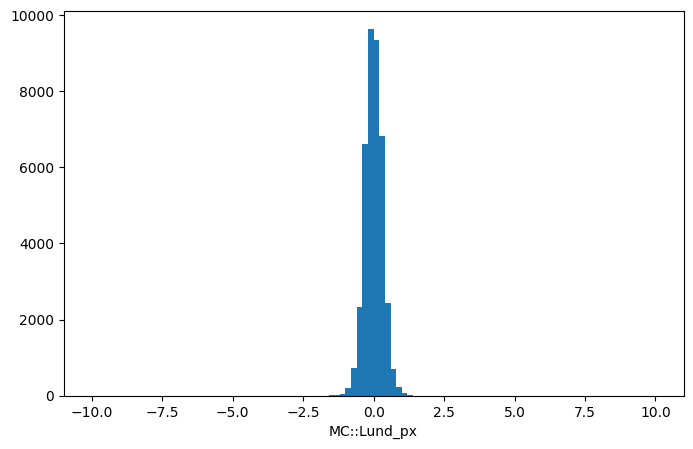

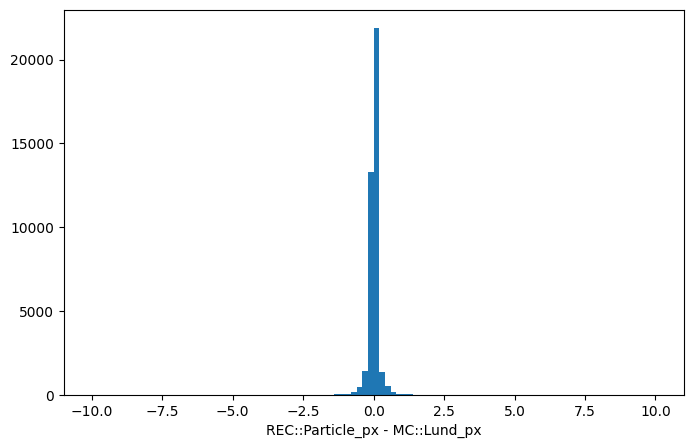

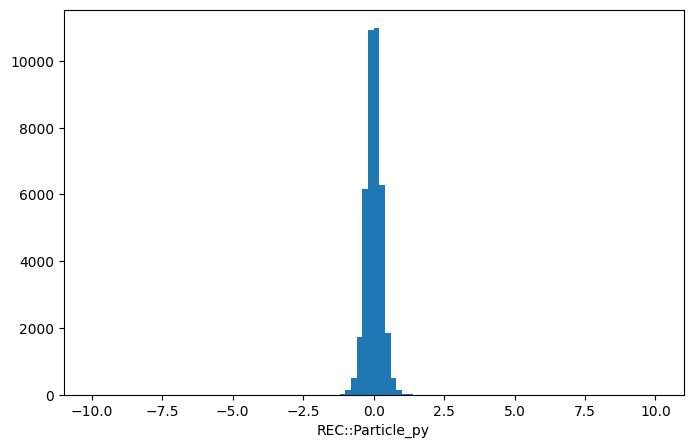

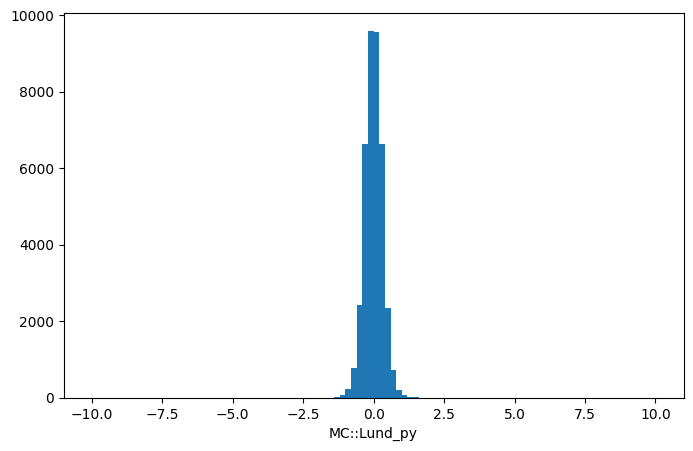

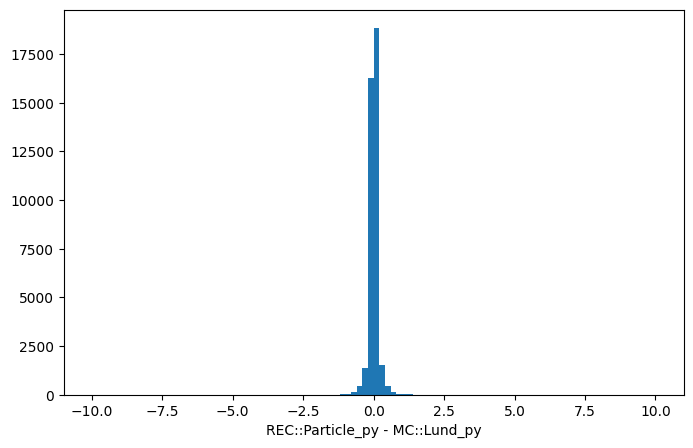

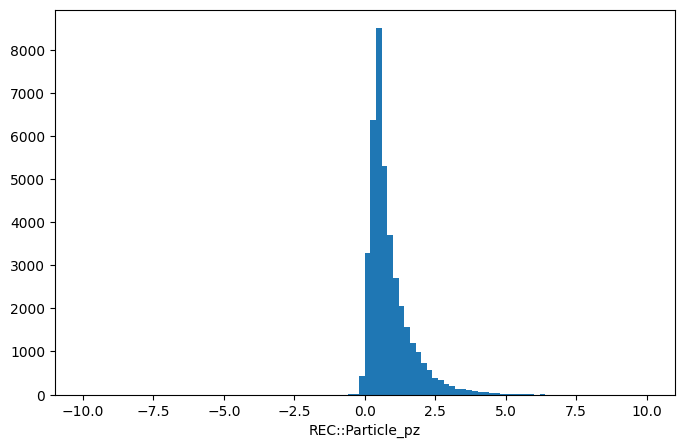

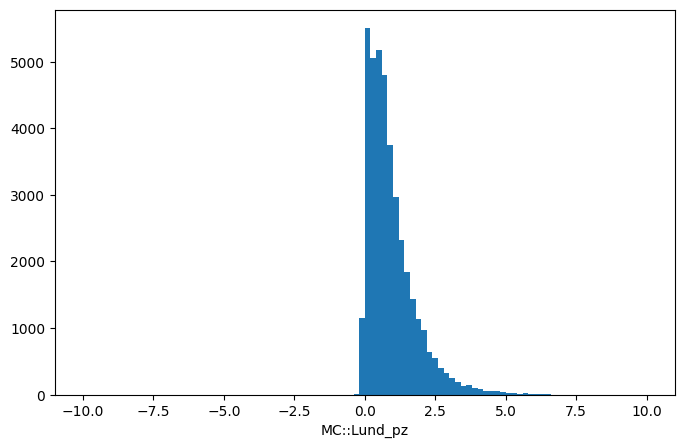

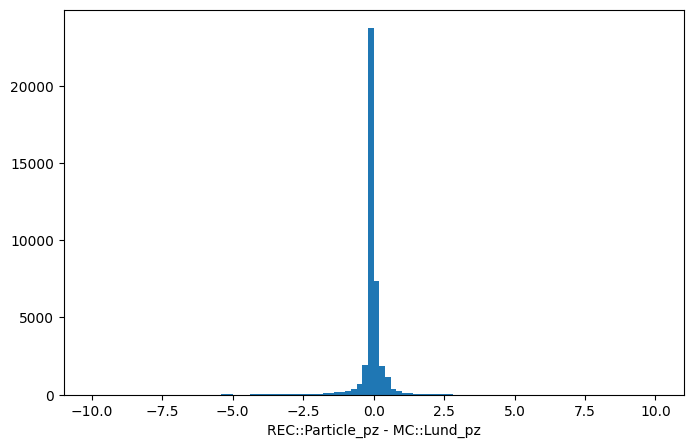

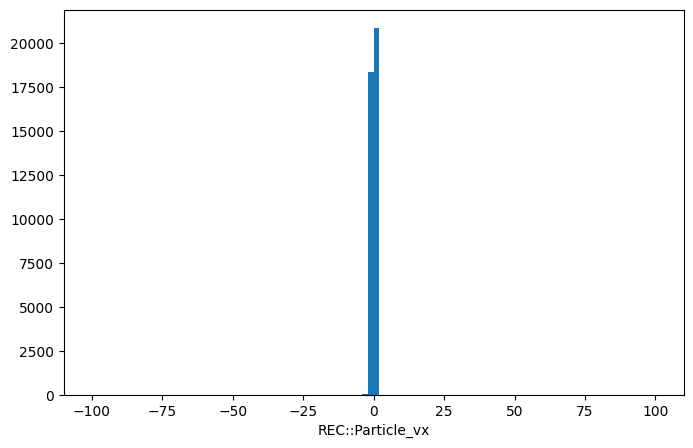

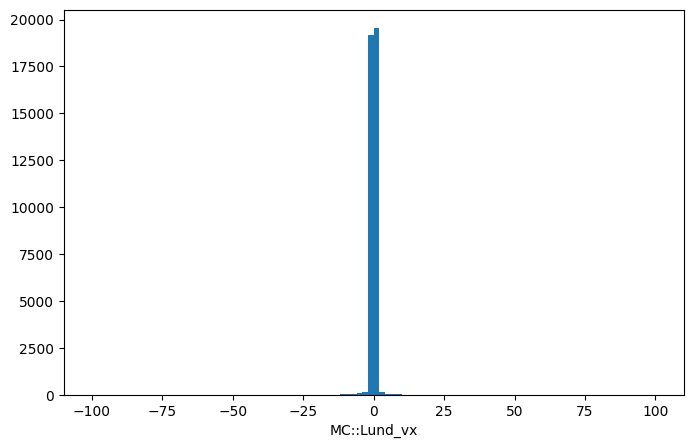

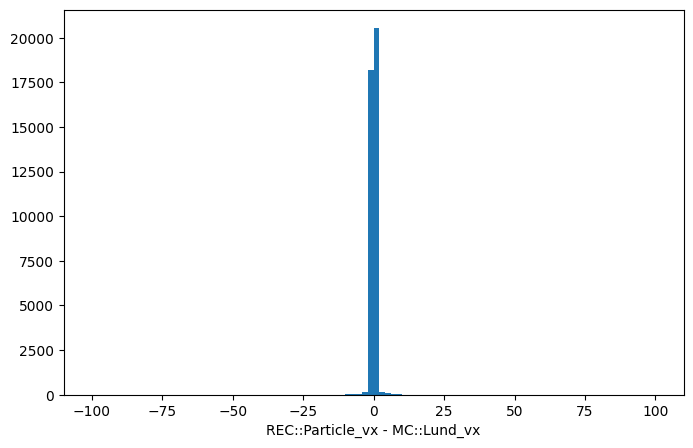

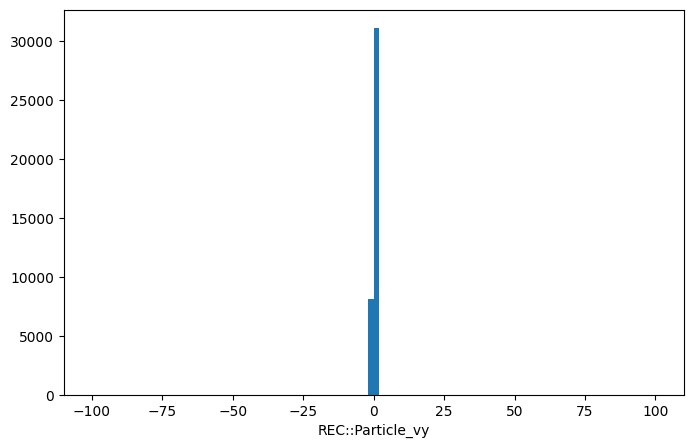

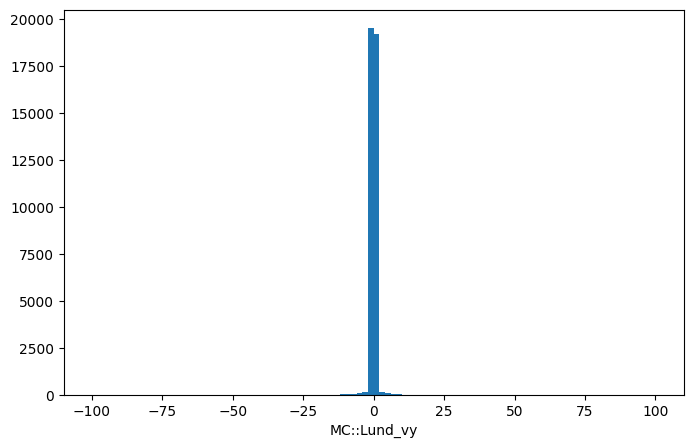

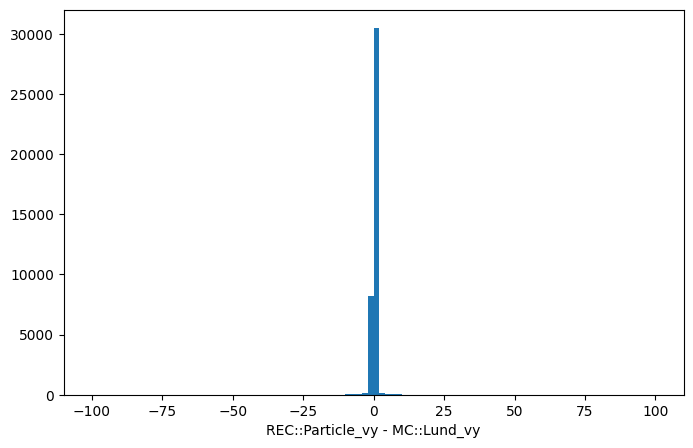

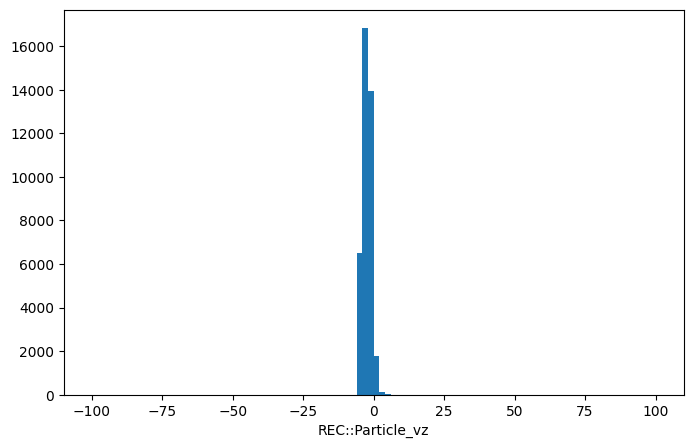

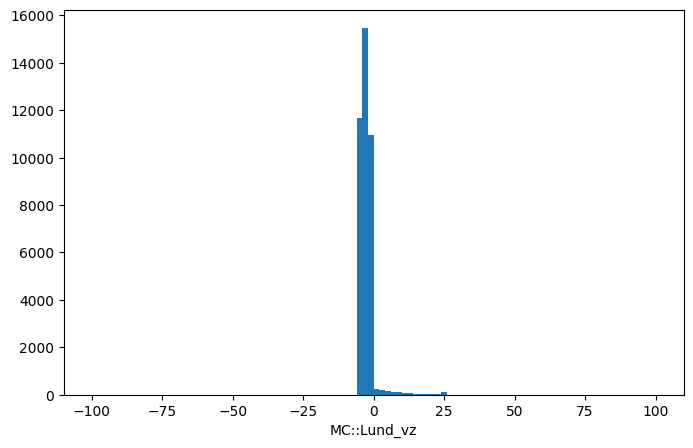

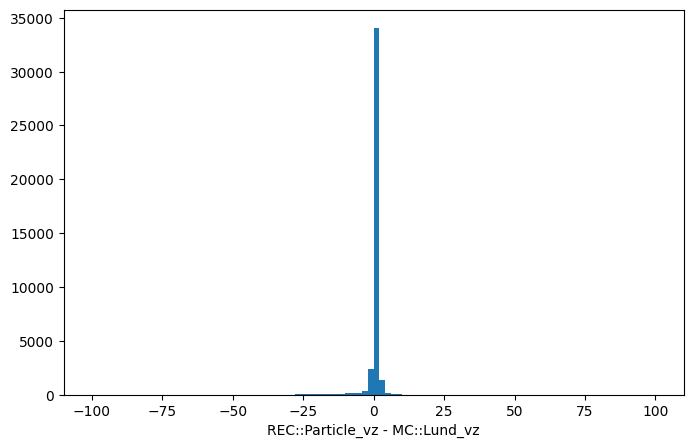

In [121]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    print("DEBUGGING: size = ",size)
    num_batches = len(dataloader)
    print("DEBUGGING: num_batches = ",num_batches)
    model.eval()
    test_loss = 0
    inputs = None
    preds = None
    tests = None
    correct = None
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            inputs = torch.concatenate((inputs,X),axis=0) if inputs is not None else X
            preds = torch.concatenate((preds,pred),axis=0) if preds is not None else pred
            tests = torch.concatenate((tests,y),axis=0) if tests is not None else y
            correct = torch.concatenate((correct,pred - y),axis=0) if correct is not None else pred - y
    test_loss /= num_batches
#     correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    
    # Copy to CPU
    inputs = inputs.cpu()
    correct = correct.cpu()
    preds = preds.cpu()
    tests = tests.cpu()
    
    print("DEBUGGING: inputs.shape = ",inputs.shape)
    print("DEBUGGING: correct.shape = ",correct.shape)
    print("DEBUGGING: preds.shape = ",preds.shape)
    print("DEBUGGING: tests.shape = ",tests.shape)
    print()
    print("DEBUGGING: correct.min() = ",correct.min().item())
    print("DEBUGGING: preds.min() = ",preds.min().item())
    print("DEBUGGING: tests.min() = ",tests.min().item())
    print()
    print("DEBUGGING: correct.max() = ",correct.max().item())
    print("DEBUGGING: preds.max() = ",preds.max().item())
    print("DEBUGGING: tests.max() = ",tests.max().item())
    print()
    print("DEBUGGING: correct.mean() = ",correct.mean().item())
    print("DEBUGGING: preds.mean() = ",preds.mean().item())
    print("DEBUGGING: tests.mean() = ",tests.mean().item())
    print()
    print("DEBUGGING: correct.std() = ",correct.std().item())
    print("DEBUGGING: preds.std() = ",preds.std().item())
    print("DEBUGGING: tests.std() = ",tests.std().item())
    
    low_high = (-10,10)
    
    # Plot differences between test and prediction
    figs = []
    for j in range(0,3):
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j])

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        print("DEBUGGING: target label = ",dataset.truth_keys[j])
        print("DEBUGGING: mean Delta   = ",correct[:,j].mean()*10)
        print("DEBUGGING: std Delta    = ",correct[:,j].std()*10)
        
        # Get original diffs
        original_deltas = np.subtract(inputs[:,j],tests[:,j])
        print("DEBUGGING: mean orig Delta   = ",original_deltas.mean()*10)
        print("DEBUGGING: std orig Delta    = ",original_deltas.std()*10)
        
        figs.extend([f1,f2,f3])
    
    low_high = (-100,100)
    
    # Plot differences between test and prediction
    for j in range(3,6):
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j])

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*50),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        
        figs.extend([f1,f2,f3])
        
    plt.show()
    
test(test_dataloader, model, loss_fn)

In [58]:
print(len(train_dataloader))

4908
